In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from model import KeywordSpottingModel
from data_loader import load_speech_commands_dataset
from utils import set_memory_GB,print_model_size, log_to_file
from augmentations import add_time_shift_noise_and_align, add_noise
from train import trainig_loop




/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

In [2]:
torch.cuda.is_available()

True

In [3]:
set_memory_GB(1)

Memory fraction set to 0.022458079576498518
Memory fraction in GB: 1.0


In [4]:
train_ds, val_ds, test_ds, info = load_speech_commands_dataset()

2024-08-29 07:55:43.699191: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 07:55:43.705196: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 07:55:43.718141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 07:55:43.739063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 07:55:43.745252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attemptin

In [5]:
# maintain seed for repructablity
np.seed = 42
# tf.random.set_seed(42)
torch.manual_seed(0)

In [6]:
label_names = info.features['label'].names
print(label_names)

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [7]:
augmentations = [
    lambda x: add_time_shift_noise_and_align(x),
    lambda x:add_noise(x,noise_level = 0.01)
]

In [8]:
from data_loader import TFDatasetAdapter2


In [9]:
# Convert the TFDS dataset to a PyTorch Dataset
fixed_length = 16000
n_mfcc = 13
n_fft = 640
hop_length = 320
n_mels = 40
pytorch_train_dataset = TFDatasetAdapter2(train_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations)
pytorch_val_dataset = TFDatasetAdapter2(val_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations=None)

2024-08-29 07:55:58.566001: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-29 07:56:00.007447: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# Create a DataLoader to feed the data into the model
batch_size = 32
train_loader = DataLoader(pytorch_train_dataset, batch_size=batch_size, shuffle=True,num_workers=4,prefetch_factor=2)
val_loader = DataLoader(pytorch_val_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

In [11]:
for audio, label in train_loader:
    print(audio.shape, label.shape)
    break


torch.Size([32, 39, 51]) torch.Size([32])


In [26]:
import torch.nn as nn
from mamba_ssm import Mamba

# Define model architecture
class KeywordSpottingModel_with_cls(nn.Module):
    def __init__(self, input_dim, d_model, d_state, d_conv, expand, label_names, num_mamba_layers=1):
        super(KeywordSpottingModel_with_cls, self).__init__()
        self.proj = nn.Linear(input_dim, d_model)  # Initial projection layer
        
        # CLS token: learnable parameter with shape [1, 1, d_model]
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))

        # Stack multiple Mamba layers with RSMNorm layer
        self.mamba_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()

        for _ in range(num_mamba_layers):
            self.mamba_layers.append(Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand))
            self.layer_norms.append(nn.modules.normalization.RMSNorm(d_model))

        self.fc = nn.Linear(d_model, len(label_names))  # Output layer
        self.dropout = nn.Dropout(0.2)  # Dropout layer with a dropout rate of 0.5

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to [batch_size, num_frames, num_mfcc]
        x = self.proj(x)  # Project input to d_model dimension
        
        # Create a CLS token and expand it across the batch dimension
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: [batch_size, 1, d_model]
        
        # Append the CLS token to the input sequence
        x = torch.cat((x, cls_tokens), dim=1)  # Shape: [batch_size, num_frames + 1, d_model]

        x = x.permute(0, 2, 1)  # Transpose to [batch_size, d_model, num_frames + 1] for Mamba
        
        for mamba_layer, layer_norm in zip(self.mamba_layers, self.layer_norms):
            x = mamba_layer(x)
            x = layer_norm(x)  # Apply RMSNorm after Mamba layer
        
        x = self.dropout(x)  # Apply dropout after Mamba layers
        
        # Extract the CLS token output (last token)
        cls_output = x[:, :, -1]  # Shape: [batch_size, d_model]
        
        x = self.fc(cls_output)
        return x

# Training loop

# With L2 regulariztion AND Droput layer

In [46]:
# Initialize model, loss function, and optimizer
input_dim = 39  # Number of MFCC features
d_model = 52  # Number of frames + 1 for CLS token
d_state = 16
d_conv = 4
expand = 2

model = KeywordSpottingModel_with_cls(input_dim=input_dim, d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, label_names=label_names, num_mamba_layers=1).to("cuda")

# class_weights = class_weights / np.sum(class_weights)  # Normalize class weights
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to("cuda")  # Convert to tensor
criterion = nn.CrossEntropyLoss().to("cuda")  # Loss function with class weights
base_optimizer = optim.Adam(model.parameters(), lr=0.0024, weight_decay=2.80475e-05) # weight_decay for L2 regulariztopn

from torch_optimizer import Lookahead

optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)  # Wrap around Adam


In [47]:
import torch.optim as optim
# Adding learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [48]:
import torch
from utils import log_to_file, EarlyStopping
from tqdm import tqdm


# Initialize the early stopping object
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# Training loop
num_epochs = 100

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Log new training session
log_to_file("\n\nNew training session\n\n","training_log_with_cls.txt")
# Log the model architecture
log_to_file(str(model),"training_log_with_cls.txt")


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for audio, labels in tqdm(train_loader):
        audio, labels = audio.to("cuda"), labels.to("cuda")

        # Forward pass
        outputs = model(audio)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%')

    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Log training metrics
    log_to_file(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%',"training_log_with_cls.txt")

    # # Step the scheduler
    # scheduler.step()

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for audio, labels in val_loader:
            audio, labels = audio.to("cuda"), labels.to("cuda")
            outputs = model(audio)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_loss_avg = val_loss / len(val_loader)
    print(f'Validation Loss: {val_loss_avg}, Validation Accuracy: {val_accuracy}%')

    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss_avg)
    
    # Step the scheduler based on validation loss
    scheduler.step(val_loss_avg)
    print(f'Learning rate after epoch {epoch+1}: {scheduler.get_last_lr()}')

    
    
    # Check early stopping condition
    if early_stopping.step(val_loss/len(val_loader)):
        print(f"Stopping training at epoch {epoch+1} due to early stopping")
        break

    # Log validation metrics
    log_to_file(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.2f}%',"training_log_with_cls.txt")

log_to_file("Training complete.","training_log_with_cls.txt")



  0%|                                                                              | 0/962 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████| 962/962 [00:40<00:00, 24.05it/s]

Epoch 1/100, Training Loss: 1.1866728645166587, Training Accuracy: 58.266436998277484%


Validation Loss: 0.6472903343624082, Validation Accuracy: 78.85498244666486%
Learning rate after epoch 1: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:41<00:00, 23.10it/s]

Epoch 2/100, Training Loss: 0.6693984726579423, Training Accuracy: 77.32132990997432%


Validation Loss: 0.5369959690704428, Validation Accuracy: 82.7977315689981%
Learning rate after epoch 2: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:40<00:00, 23.69it/s]

Epoch 3/100, Training Loss: 0.5681180316188107, Training Accuracy: 80.99710747830609%


Validation Loss: 0.4784565208287075, Validation Accuracy: 84.03996759384283%
Learning rate after epoch 3: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:40<00:00, 23.75it/s]

Epoch 4/100, Training Loss: 0.5122136948959372, Training Accuracy: 82.35236764275732%


Validation Loss: 0.43378450528814877, Validation Accuracy: 86.01134215500946%
Learning rate after epoch 4: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:41<00:00, 22.96it/s]


Epoch 5/100, Training Loss: 0.47582334254455916, Training Accuracy: 83.78887841658812%
Validation Loss: 0.4114263731472451, Validation Accuracy: 86.36240885768296%
Learning rate after epoch 5: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:42<00:00, 22.49it/s]

Epoch 6/100, Training Loss: 0.44606302220087785, Training Accuracy: 84.93613702102766%


Validation Loss: 0.36335049588875523, Validation Accuracy: 88.36078854982446%
Learning rate after epoch 6: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:39<00:00, 24.49it/s]


Epoch 7/100, Training Loss: 0.4304188043731042, Training Accuracy: 85.33589001917514%
Validation Loss: 0.3599566052956828, Validation Accuracy: 88.41479881177423%
Learning rate after epoch 7: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:39<00:00, 24.44it/s]

Epoch 8/100, Training Loss: 0.41526087825021973, Training Accuracy: 85.71614287107154%


Validation Loss: 0.3362575739236741, Validation Accuracy: 88.87388603834728%
Learning rate after epoch 8: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:38<00:00, 24.87it/s]

Epoch 9/100, Training Loss: 0.3952300011368155, Training Accuracy: 86.51564886736651%


Validation Loss: 0.35727059205287487, Validation Accuracy: 88.68485012152308%
Learning rate after epoch 9: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:37<00:00, 25.40it/s]

Epoch 10/100, Training Loss: 0.3782924493221012, Training Accuracy: 87.20790405928044%


Validation Loss: 0.34134668985317496, Validation Accuracy: 89.11693221712126%
Learning rate after epoch 10: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:37<00:00, 25.89it/s]

Epoch 11/100, Training Loss: 0.363941714640033, Training Accuracy: 87.46140596054471%


Validation Loss: 0.3263013856485486, Validation Accuracy: 89.52200918174454%
Learning rate after epoch 11: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:38<00:00, 24.81it/s]


Epoch 12/100, Training Loss: 0.36094067297612553, Training Accuracy: 87.75715817868634%
Validation Loss: 0.30777134646757925, Validation Accuracy: 90.33216311099109%
Learning rate after epoch 12: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:37<00:00, 25.41it/s]


Epoch 13/100, Training Loss: 0.34313634702482737, Training Accuracy: 88.25766193246449%
Validation Loss: 0.3025855825700123, Validation Accuracy: 90.03510667026735%
Learning rate after epoch 13: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:38<00:00, 24.90it/s]

Epoch 14/100, Training Loss: 0.35486329377100273, Training Accuracy: 88.02691020182651%


Validation Loss: 0.31354902055242967, Validation Accuracy: 89.7650553605185%
Learning rate after epoch 14: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:36<00:00, 26.11it/s]

Epoch 15/100, Training Loss: 0.3300379093411125, Training Accuracy: 88.67366505248789%


Validation Loss: 0.3262005791967285, Validation Accuracy: 89.7650553605185%
Learning rate after epoch 15: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:36<00:00, 26.05it/s]

Epoch 16/100, Training Loss: 0.3205266095728859, Training Accuracy: 89.01816763625727%


Validation Loss: 0.2895465922574031, Validation Accuracy: 90.98028625438833%
Learning rate after epoch 16: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:37<00:00, 25.84it/s]

Epoch 17/100, Training Loss: 0.3103606219204015, Training Accuracy: 89.36592024440183%


Validation Loss: 0.32664503539302225, Validation Accuracy: 90.19713745611666%
Learning rate after epoch 17: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:36<00:00, 26.25it/s]

Epoch 18/100, Training Loss: 0.3067070902392981, Training Accuracy: 89.55117163378725%


Validation Loss: 0.2728786747742059, Validation Accuracy: 91.00729138536322%
Learning rate after epoch 18: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:38<00:00, 24.67it/s]

Epoch 19/100, Training Loss: 0.2991993458953196, Training Accuracy: 89.68442263316975%


Validation Loss: 0.29116379874276704, Validation Accuracy: 91.19632730218741%
Learning rate after epoch 19: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:39<00:00, 24.59it/s]

Epoch 20/100, Training Loss: 0.2950305119195562, Training Accuracy: 89.91517436380772%


Validation Loss: 0.297560700199342, Validation Accuracy: 90.71023494463948%
Learning rate after epoch 20: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:36<00:00, 26.57it/s]

Epoch 21/100, Training Loss: 0.2906928880260231, Training Accuracy: 90.00292502193767%


Validation Loss: 0.2732638193230177, Validation Accuracy: 91.65541452876046%
Learning rate after epoch 21: [0.0024]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:37<00:00, 25.63it/s]

Epoch 22/100, Training Loss: 0.2806349381912895, Training Accuracy: 90.204426533199%


Validation Loss: 0.29082093177491736, Validation Accuracy: 91.06130164731299%
Learning rate after epoch 22: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:38<00:00, 24.90it/s]

Epoch 23/100, Training Loss: 0.2470986014987166, Training Accuracy: 91.49468621014658%


Validation Loss: 0.2667560845067532, Validation Accuracy: 92.16851201728328%
Learning rate after epoch 23: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:34<00:00, 27.77it/s]

Epoch 24/100, Training Loss: 0.23395546748963128, Training Accuracy: 91.87493906204297%


Validation Loss: 0.2627403812868328, Validation Accuracy: 92.49257358898191%
Learning rate after epoch 24: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:34<00:00, 27.65it/s]

Epoch 25/100, Training Loss: 0.23163699687084885, Training Accuracy: 91.96593974454808%


Validation Loss: 0.2557984722440998, Validation Accuracy: 92.30353767215772%
Learning rate after epoch 25: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:35<00:00, 27.48it/s]

Epoch 26/100, Training Loss: 0.2305455687368703, Training Accuracy: 92.04719035392766%


Validation Loss: 0.2566190742534296, Validation Accuracy: 92.24952741020795%
Learning rate after epoch 26: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:35<00:00, 27.07it/s]

Epoch 27/100, Training Loss: 0.22754976502087224, Training Accuracy: 92.14144106080795%


Validation Loss: 0.25479569726077644, Validation Accuracy: 92.24952741020795%
Learning rate after epoch 27: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:36<00:00, 26.47it/s]

Epoch 28/100, Training Loss: 0.22524598127583395, Training Accuracy: 92.0959407195554%


Validation Loss: 0.25963608173107533, Validation Accuracy: 92.22252227923306%
Learning rate after epoch 28: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:35<00:00, 26.85it/s]


Epoch 29/100, Training Loss: 0.22239240322924236, Training Accuracy: 92.37869284019631%
Validation Loss: 0.2546954767071995, Validation Accuracy: 92.41155819605726%
Learning rate after epoch 29: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:38<00:00, 25.23it/s]


Epoch 30/100, Training Loss: 0.2227245034657713, Training Accuracy: 92.2649419870649%
Validation Loss: 0.2577663124860104, Validation Accuracy: 92.54658385093168%
Learning rate after epoch 30: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:40<00:00, 23.56it/s]

Epoch 31/100, Training Loss: 0.22221482728788022, Training Accuracy: 92.15444115830869%


Validation Loss: 0.25666461525292233, Validation Accuracy: 92.27653254118283%
Learning rate after epoch 31: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:35<00:00, 27.31it/s]

Epoch 32/100, Training Loss: 0.22241239569957316, Training Accuracy: 92.18694140206051%


Validation Loss: 0.25219215936798217, Validation Accuracy: 92.62759924385634%
Learning rate after epoch 32: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:37<00:00, 25.46it/s]

Epoch 33/100, Training Loss: 0.22081536593848913, Training Accuracy: 92.33644252331892%


Validation Loss: 0.25199873669972195, Validation Accuracy: 92.43856332703214%
Learning rate after epoch 33: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:35<00:00, 26.87it/s]

Epoch 34/100, Training Loss: 0.21638653000135152, Training Accuracy: 92.58994442458318%


Validation Loss: 0.25162560100153347, Validation Accuracy: 92.5195787199568%
Learning rate after epoch 34: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:35<00:00, 27.11it/s]

Epoch 35/100, Training Loss: 0.21247054159780673, Training Accuracy: 92.51844388832916%


Validation Loss: 0.25833293227157716, Validation Accuracy: 92.30353767215772%
Learning rate after epoch 35: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:33<00:00, 28.39it/s]

Epoch 36/100, Training Loss: 0.2155158306015055, Training Accuracy: 92.586694400208%


Validation Loss: 0.2558232877435612, Validation Accuracy: 92.30353767215772%
Learning rate after epoch 36: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:34<00:00, 27.65it/s]

Epoch 37/100, Training Loss: 0.21564670019006654, Training Accuracy: 92.24544184081381%


Validation Loss: 0.24978019894453987, Validation Accuracy: 92.41155819605726%
Learning rate after epoch 37: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:36<00:00, 26.58it/s]

Epoch 38/100, Training Loss: 0.21523548137752838, Training Accuracy: 92.56394422958172%


Validation Loss: 0.2501407975716324, Validation Accuracy: 92.5195787199568%
Learning rate after epoch 38: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:35<00:00, 26.77it/s]

Epoch 39/100, Training Loss: 0.21046573584299078, Training Accuracy: 92.67119503396276%


Validation Loss: 0.2509171936885807, Validation Accuracy: 92.43856332703214%
Learning rate after epoch 39: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:35<00:00, 27.27it/s]


Epoch 40/100, Training Loss: 0.21183096532847367, Training Accuracy: 92.61919464395983%
Validation Loss: 0.25296807921780595, Validation Accuracy: 92.5195787199568%
Learning rate after epoch 40: [0.00023999999999999998]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:36<00:00, 26.27it/s]

Epoch 41/100, Training Loss: 0.208392311384216, Training Accuracy: 92.8141961064708%


Validation Loss: 0.260573113172572, Validation Accuracy: 92.30353767215772%
Learning rate after epoch 41: [2.4e-05]


100%|████████████████████████████████████████████████████████████████████| 962/962 [00:34<00:00, 27.63it/s]

Epoch 42/100, Training Loss: 0.2119686929354146, Training Accuracy: 92.54444408333063%


Validation Loss: 0.2540000580363618, Validation Accuracy: 92.46556845800703%
Learning rate after epoch 42: [2.4e-05]
Early stopping triggered
Stopping training at epoch 42 due to early stopping


In [50]:
# load test data
pytorch_test_dataset = TFDatasetAdapter2(test_ds, fixed_length, n_mfcc, n_fft, hop_length, n_mels, augmentations=None)
test_loader = DataLoader(pytorch_test_dataset, batch_size=batch_size, shuffle=False,num_workers=4,prefetch_factor=2)

# Evaluate the model on the test set
accuracy = 0
total = 0
model.eval()

with torch.no_grad():
    for audio, labels in test_loader:
        audio, labels = audio.to("cuda"), labels.to("cuda")
        outputs = model(audio)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
test_accuracy = 100 * accuracy / total
print(f'Test Accuracy: {test_accuracy}%')





Test Accuracy: 92.93078055964654%


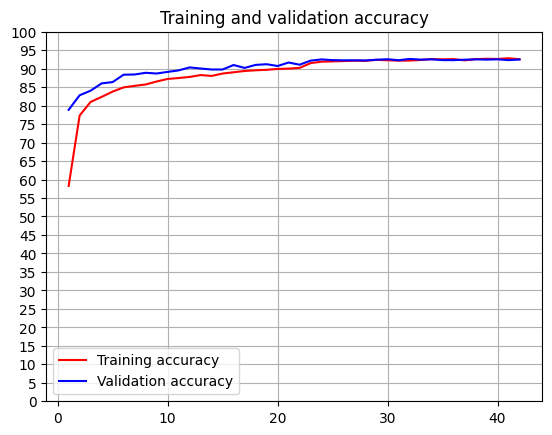

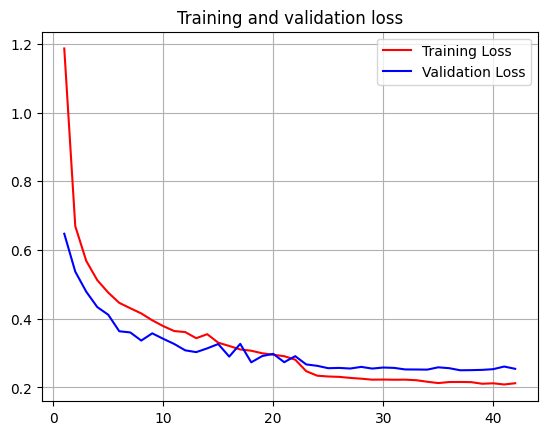

In [54]:
from utils import plot_learning_curves

plot_learning_curves(train_accuracies, val_accuracies, train_losses, val_losses)

In [51]:
import pandas as pd
from utils import compute_inference_GPU_mem
#save model size(macs, params) and accuracy
macs, params = print_model_size(model,input_size=torch.randn(batch_size, input_dim, d_model-1).to("cuda"))
macs = macs/1e9
accuracy = test_accuracy
data = {'Model': ['KeywordSpottingModel_RSM_Norm_0-1-2_order_cls'], 'GMACs': [macs], 'Params': [params], 'Accuracy': [accuracy]}
model_config = {'input_dim': input_dim, 'd_model': d_model, 'd_state': d_state, 'd_conv': d_conv, 'expand': expand}
data.update(model_config)
inf_GPU_mem = compute_inference_GPU_mem(model, input=torch.randn(1, input_dim, d_model-1).to("cuda"))
#inference macs and params
inf_macs, inf_params = print_model_size(model,input_size=torch.randn(1, input_dim, d_model-1).to("cuda"))
inference_data = {'Inference CUDA Mem in MB': [inf_GPU_mem], 'Inference GMACs': [inf_macs/1e9], 'Inference Params': [inf_params]}
data.update(inference_data)
df = pd.DataFrame(data, index=[0])
df.to_csv('results.csv', mode='a', header=False)

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.

MACs: 41553720.0 Which are 0.04155372 Giga-MACs, Params: 25492.0

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Customize rule calculate_MAMBA_flops() <class 'mamba_ssm.modules.mamba_simple.Mamba'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.

MACs: 2116140.0 Which are 0.00211614 Giga-MACs, Params: 25492.0



In [64]:
with torch.profiler.profile(with_flops=True) as prof:
    model(torch.randn(32, input_dim, d_model-1).to("cuda"))

# Print FLOPs
print(prof.key_averages().table(sort_by="flops"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total KFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                               aten::mm         4.65%     342.751us         6.26%     461.124us      92.225us      30.080us        20.37%      30.080us       6.016us             5     74457.344  
                                              aten::mul         0.91%      66.738us         1.22%      89.993us      44.996us       6.048us         4.1